# Classification

Here we will split our training data into a training and validation sets and compute classification accuracy.

In [1]:
import pandas as pd

import seaborn as sns

# load the scikit learn package
import sklearn
from sklearn import model_selection
from sklearn.ensemble import RandomForestClassifier

In [2]:
# load data from csv file
butterflies = pd.read_csv('data/butterflies.csv')

<AxesSubplot:xlabel='Width', ylabel='Height'>

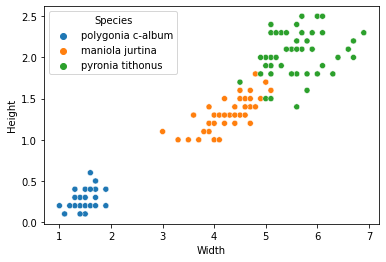

In [3]:
# plot the dataset
sns.scatterplot(data=butterflies, x="Width", y="Height", hue="Species")

In [4]:
# split the data into validation and test
# randomly choose take 50 datapoints for validation
train_data, validation_data = model_selection.train_test_split(butterflies, test_size=50)

In [5]:
print("Number of training samples: ", len(train_data))
print("Number of validation samples: ", len(validation_data))

Number of training samples:  52
Number of validation samples:  50


<AxesSubplot:xlabel='Width', ylabel='Height'>

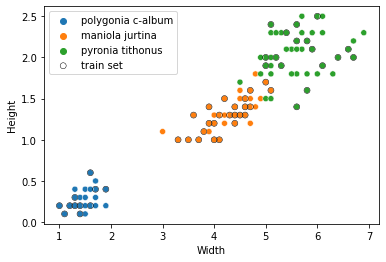

In [6]:
# draw the dataset
sns.scatterplot(data=butterflies, x="Width", y="Height", hue="Species")

# with circles around the training set
sns.scatterplot(
    data=train_data,
    x="Width",
    y="Height",
    marker="o",
    edgecolor="black",
    facecolor="none",
    label="train set",
)

In [7]:
# train the classifier
rf = RandomForestClassifier()
rf.fit(train_data[["Width", "Height"]], train_data["Species"])

RandomForestClassifier()

In [8]:
# make predictions for the validation set
species_prediction = rf.predict(validation_data[["Width", "Height"]])

In [9]:
# compute the classification accuracy on the validation set
correct_classifications = validation_data["Species"] == species_prediction
percent_correct_predictions = correct_classifications.mean() * 100
percent_incorrect_predictions = (1 - correct_classifications).mean() * 100
print("Classification accuracy (%):", percent_correct_predictions)

Classification accuracy (%): 90.0


In [10]:
# extract the incorrect predictions so we can plot them
incorrect_predictions = validation_data[~correct_classifications]

<AxesSubplot:xlabel='Width', ylabel='Height'>

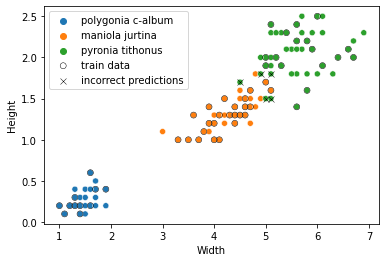

In [11]:
# draw the dataset
sns.scatterplot(data=butterflies, x="Width", y="Height", hue="Species")

# with circles around the training set
sns.scatterplot(
    data=train_data,
    x="Width",
    y="Height",
    marker="o",
    edgecolor="black",
    facecolor="none",
    label="train data",
)

# draw an 'x' where we predict the wrong answer
sns.scatterplot(
    data=incorrect_predictions,
    x="Width",
    y="Height",
    marker="x",
    color="black",
    label="incorrect predictions",
)